# Introduction to Time Series Analysis

**Date:** 30 October 2025

**Topic:** Fundamental concepts and techniques in time series analysis

This notebook covers:
1. Time Series Data Loading and Visualization
2. Stationarity Testing (ADF and KPSS Tests)
3. Autocorrelation and Partial Autocorrelation Analysis
4. Time Series Components and Decomposition
5. Basic Forecasting Methods
6. Model Evaluation Techniques

## 1. Setup and Dependencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Time series specific libraries
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

# Statistical libraries
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

## 2. Synthetic Energy Consumption Dataset

### 2.1 Dataset Generation

In [2]:
# Create synthetic energy consumption dataset
np.random.seed(42)

# Generate time series data for one year with hourly frequency
start_date = '2022-01-01'
end_date = '2022-12-31 23:00:00'
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

n_observations = len(date_range)
print(f"Generating {n_observations} hourly observations from {start_date} to {end_date}")

# Generate synthetic features
np.random.seed(42)
temperature_base = 20 + 10 * np.sin(2 * np.pi * np.arange(n_observations) / (24 * 365)) + np.random.normal(0, 2, n_observations)
humidity = np.random.uniform(30, 80, n_observations)
square_footage = np.random.uniform(1000, 2000, n_observations)
occupancy = np.random.poisson(5, n_observations)
renewable_energy = np.random.exponential(10, n_observations)

# Create realistic energy consumption pattern
# Base consumption with daily and seasonal patterns
daily_pattern = 50 + 20 * np.sin(2 * np.pi * np.arange(n_observations) / 24)  # Daily cycle
seasonal_pattern = 10 * np.sin(2 * np.pi * np.arange(n_observations) / (24 * 365))  # Seasonal cycle
temperature_effect = 0.5 * np.abs(temperature_base - 22)  # Higher consumption when temp far from 22°C
occupancy_effect = 2 * occupancy
random_noise = np.random.normal(0, 5, n_observations)

energy_consumption = (daily_pattern + seasonal_pattern + temperature_effect + 
                     occupancy_effect + random_noise)

# Ensure positive values
energy_consumption = np.maximum(energy_consumption, 10)

# Create DataFrame
energy_data = pd.DataFrame({
    'Timestamp': date_range,
    'Temperature': temperature_base,
    'Humidity': humidity,
    'SquareFootage': square_footage,
    'Occupancy': occupancy,
    'HVACUsage': np.random.choice(['On', 'Off'], n_observations),
    'LightingUsage': np.random.choice(['On', 'Off'], n_observations),
    'RenewableEnergy': renewable_energy,
    'DayOfWeek': [date.strftime('%A') for date in date_range],
    'Holiday': np.random.choice(['Yes', 'No'], n_observations, p=[0.05, 0.95]),
    'EnergyConsumption': energy_consumption
})

# Set timestamp as index
energy_data = energy_data.set_index('Timestamp')

print(f"\nDataset created with shape: {energy_data.shape}")
print(f"Date range: {energy_data.index.min()} to {energy_data.index.max()}")
print(f"\nFirst few rows:")
display(energy_data.head())

Generating 8760 hourly observations from 2022-01-01 to 2022-12-31 23:00:00

Dataset created with shape: (8760, 10)
Date range: 2022-01-01 00:00:00 to 2022-12-31 23:00:00

First few rows:


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,20.993428,44.614509,1653.917788,5,On,Off,31.161807,Saturday,No,74.932031
2022-01-01 01:00:00,19.730644,62.788865,1620.342861,5,On,Off,0.892675,Saturday,No,71.756569
2022-01-01 02:00:00,21.309722,62.081000,1704.984638,9,On,Off,3.674090,Saturday,No,78.041210
2022-01-01 03:00:00,23.067577,40.474311,1082.381739,8,On,Off,3.542461,Saturday,No,80.661122
2022-01-01 04:00:00,19.560384,31.519871,1355.648433,6,Off,On,13.209318,Saturday,No,69.936245


### 2.2 Data Quality Check

In [3]:
# Check for missing values and basic statistics
print("Data Quality Assessment:")
print("=" * 30)

# Missing values
missing_values = energy_data.isnull().sum()
print(f"\nMissing values per column:")
for col, missing in missing_values.items():
    print(f"{col:20}: {missing:3}")

print(f"\nTotal missing values: {missing_values.sum()}")

# Basic statistics for numeric columns
print(f"\nBasic statistics for key variables:")
key_vars = ['Temperature', 'EnergyConsumption', 'Occupancy', 'RenewableEnergy']
display(energy_data[key_vars].describe())

# Check data types
print(f"\nData types:")
for col, dtype in energy_data.dtypes.items():
    print(f"{col:20}: {dtype}")

Data Quality Assessment:

Missing values per column:
Temperature         :   0
Humidity            :   0
SquareFootage       :   0
Occupancy           :   0
HVACUsage           :   0
LightingUsage       :   0
RenewableEnergy     :   0
DayOfWeek           :   0
Holiday             :   0
EnergyConsumption   :   0

Total missing values: 0

Basic statistics for key variables:


,Temperature,EnergyConsumption,Occupancy,RenewableEnergy
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,19.998893,63.354351,5.013927,10.065163
std,7.390892,16.842431,2.232678,10.077914
min,4.382131,19.837224,0.000000,0.001288
25%,13.184535,50.174576,3.000000,2.788073
50%,20.076517,63.486579,5.000000,6.984197
75%,26.855146,76.319584,6.000000,14.143961
max,36.600990,115.312830,17.000000,117.413709



Data types:
Temperature         : float64
Humidity            : float64
SquareFootage       : float64
Occupancy           : int64
HVACUsage           : object
LightingUsage       : object
RenewableEnergy     : float64
DayOfWeek           : object
Holiday             : object
EnergyConsumption   : float64


## 3. Time Series Visualization

### 3.1 Interactive Time Series Plot

In [4]:
# Create interactive plot using Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=energy_data.index,
        y=energy_data['EnergyConsumption'],
        mode='lines',
        name='Energy Consumption',
        line=dict(color='blue', width=1)
    )
)

fig.update_layout(
    title={
        'text': "Energy Consumption Over Time (Hourly Data)",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title="Time",
    yaxis_title="Energy Consumption (kWh)",
    template="plotly_white",
    width=1000,
    height=500
)

fig.show()

# Summary statistics
print(f"\nEnergy Consumption Summary:")
print(f"Mean: {energy_data['EnergyConsumption'].mean():.2f} kWh")
print(f"Std: {energy_data['EnergyConsumption'].std():.2f} kWh")
print(f"Min: {energy_data['EnergyConsumption'].min():.2f} kWh")
print(f"Max: {energy_data['EnergyConsumption'].max():.2f} kWh")
print(f"Range: {energy_data['EnergyConsumption'].max() - energy_data['EnergyConsumption'].min():.2f} kWh")


Energy Consumption Summary:
Mean: 63.35 kWh
Std: 16.84 kWh
Min: 19.84 kWh
Max: 115.31 kWh
Range: 95.48 kWh


### 3.2 Multiple Time Series Visualization

In [5]:
# Create subplots for multiple variables
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Energy Consumption', 'Temperature', 'Occupancy', 'Renewable Energy'),
    vertical_spacing=0.08
)

# Sample data for better visualization (every 24th point for daily averages)
sample_data = energy_data.resample('D').mean()

# Energy Consumption
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['EnergyConsumption'],
              mode='lines', name='Energy Consumption', line=dict(color='blue')),
    row=1, col=1
)

# Temperature
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['Temperature'],
              mode='lines', name='Temperature', line=dict(color='red')),
    row=1, col=2
)

# Occupancy
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['Occupancy'],
              mode='lines', name='Occupancy', line=dict(color='green')),
    row=2, col=1
)

# Renewable Energy
fig.add_trace(
    go.Scatter(x=sample_data.index, y=sample_data['RenewableEnergy'],
              mode='lines', name='Renewable Energy', line=dict(color='orange')),
    row=2, col=2
)

fig.update_layout(
    title_text="Daily Average Time Series Components",
    showlegend=False,
    height=600
)

fig.show()

TypeError: agg function failed [how->mean,dtype->object]

## 4. Stationarity Testing

### 4.1 Statistical Tests Implementation

In [6]:
# Define stationarity testing functions
def adf_test(series, name="Series"):
    """
    Perform Augmented Dickey-Fuller test for stationarity
    H0: Series has unit root (non-stationary)
    H1: Series is stationary
    """
    result = adfuller(series, autolag="AIC")
    
    output = {
        'test_statistic': result[0],
        'pvalue': result[1],
        'n_lags': result[2],
        'n_observations': result[3],
        'critical_values': result[4],
        'ic_best': result[5]
    }
    
    print(f"\nAugmented Dickey-Fuller Test - {name}")
    print("=" * 50)
    print(f"Test Statistic: {output['test_statistic']:.6f}")
    print(f"p-value: {output['pvalue']:.6f}")
    print(f"Number of lags: {output['n_lags']}")
    print(f"Number of observations: {output['n_observations']}")
    
    print("\nCritical Values:")
    for key, value in output['critical_values'].items():
        print(f"\t{key}: {value:.3f}")
    
    # Interpretation
    alpha = 0.05
    if output['pvalue'] <= alpha:
        print(f"\nResult: STATIONARY (p-value {output['pvalue']:.6f} <= {alpha})")
        print("Reject null hypothesis - series does not have unit root")
    else:
        print(f"\nResult: NON-STATIONARY (p-value {output['pvalue']:.6f} > {alpha})")
        print("Fail to reject null hypothesis - series has unit root")
    
    return output


def kpss_test(series, regression="c", name="Series"):
    """
    Perform KPSS test for stationarity
    H0: Series is stationary
    H1: Series has unit root (non-stationary)
    """
    try:
        statistic, pvalue, n_lags, critical_values = kpss(series, regression=regression, nlags="auto")
        
        output = {
            'test_statistic': statistic,
            'pvalue': pvalue,
            'n_lags': n_lags,
            'critical_values': critical_values,
            'regression': regression
        }
        
        print(f"\nKPSS Test - {name}")
        print("=" * 30)
        print(f"Test Statistic: {output['test_statistic']:.6f}")
        print(f"p-value: {output['pvalue']:.6f}")
        print(f"Number of lags: {output['n_lags']}")
        print(f"Regression type: {output['regression']}")
        
        print("\nCritical Values:")
        for key, value in output['critical_values'].items():
            print(f"\t{key}: {value:.3f}")
        
        # Interpretation
        alpha = 0.05
        if output['pvalue'] <= alpha:
            print(f"\nResult: NON-STATIONARY (p-value {output['pvalue']:.6f} <= {alpha})")
            print("Reject null hypothesis - series is not stationary")
        else:
            print(f"\nResult: STATIONARY (p-value {output['pvalue']:.6f} > {alpha})")
            print("Fail to reject null hypothesis - series is stationary")
        
        return output
        
    except Exception as e:
        print(f"\nKPSS test failed for {name}: {str(e)}")
        return None


def comprehensive_stationarity_test(series, name="Series"):
    """
    Perform both ADF and KPSS tests and provide combined interpretation
    """
    print(f"\nCOMPREHENSIVE STATIONARITY ANALYSIS: {name.upper()}")
    print("=" * 70)
    
    # Perform tests
    adf_result = adf_test(series, name)
    kpss_result = kpss_test(series, name=name)
    
    # Combined interpretation
    print(f"\n" + "=" * 70)
    print("COMBINED INTERPRETATION:")
    
    adf_stationary = adf_result['pvalue'] <= 0.05
    kpss_stationary = (kpss_result['pvalue'] > 0.05) if kpss_result else None
    
    if adf_stationary and kpss_stationary:
        conclusion = "STATIONARY - Both tests agree"
    elif not adf_stationary and not kpss_stationary:
        conclusion = "NON-STATIONARY - Both tests agree"
    elif adf_stationary and not kpss_stationary:
        conclusion = "DIFFERENCE STATIONARY - Mixed signals"
    elif not adf_stationary and kpss_stationary:
        conclusion = "TREND STATIONARY - Mixed signals"
    else:
        conclusion = "INCONCLUSIVE - Unable to determine"
    
    print(f"Final Conclusion: {conclusion}")
    print("=" * 70)
    
    return {
        'adf_result': adf_result,
        'kpss_result': kpss_result,
        'conclusion': conclusion
    }

### 4.2 Energy Consumption Stationarity Analysis

In [7]:
# Test stationarity of energy consumption series
energy_series = energy_data['EnergyConsumption']
stationarity_result = comprehensive_stationarity_test(energy_series, "Energy Consumption")


COMPREHENSIVE STATIONARITY ANALYSIS: ENERGY CONSUMPTION

Augmented Dickey-Fuller Test - Energy Consumption
Test Statistic: -3.064292
p-value: 0.029311
Number of lags: 35
Number of observations: 8724

Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Result: STATIONARY (p-value 0.029311 <= 0.05)
Reject null hypothesis - series does not have unit root

KPSS Test - Energy Consumption
Test Statistic: 13.404729
p-value: 0.010000
Number of lags: 41
Regression type: c

Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

Result: NON-STATIONARY (p-value 0.010000 <= 0.05)
Reject null hypothesis - series is not stationary

COMBINED INTERPRETATION:
Final Conclusion: DIFFERENCE STATIONARY - Mixed signals


### 4.3 Differencing for Stationarity

In [8]:
# If series is non-stationary, apply differencing
if "NON-STATIONARY" in stationarity_result['conclusion']:
    print("\nApplying first differencing to achieve stationarity...")
    
    # First difference
    energy_diff = energy_series.diff().dropna()
    
    # Test stationarity of differenced series
    diff_result = comprehensive_stationarity_test(energy_diff, "First Differenced Energy Consumption")
    
    # Visualize original vs differenced series
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Original series
    ax1.plot(energy_series.index[:1000], energy_series.iloc[:1000], color='blue', linewidth=1)
    ax1.set_title('Original Energy Consumption Series (First 1000 observations)')
    ax1.set_ylabel('Energy Consumption (kWh)')
    ax1.grid(True, alpha=0.3)
    
    # Differenced series
    ax2.plot(energy_diff.index[:1000], energy_diff.iloc[:1000], color='red', linewidth=1)
    ax2.set_title('First Differenced Energy Consumption Series (First 1000 observations)')
    ax2.set_ylabel('Change in Energy Consumption')
    ax2.set_xlabel('Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\nSeries is already stationary - no differencing needed.")
    energy_diff = energy_series
    diff_result = stationarity_result


Series is already stationary - no differencing needed.


## 5. Autocorrelation Analysis

### 5.1 ACF and PACF Analysis

AUTOCORRELATION ANALYSIS


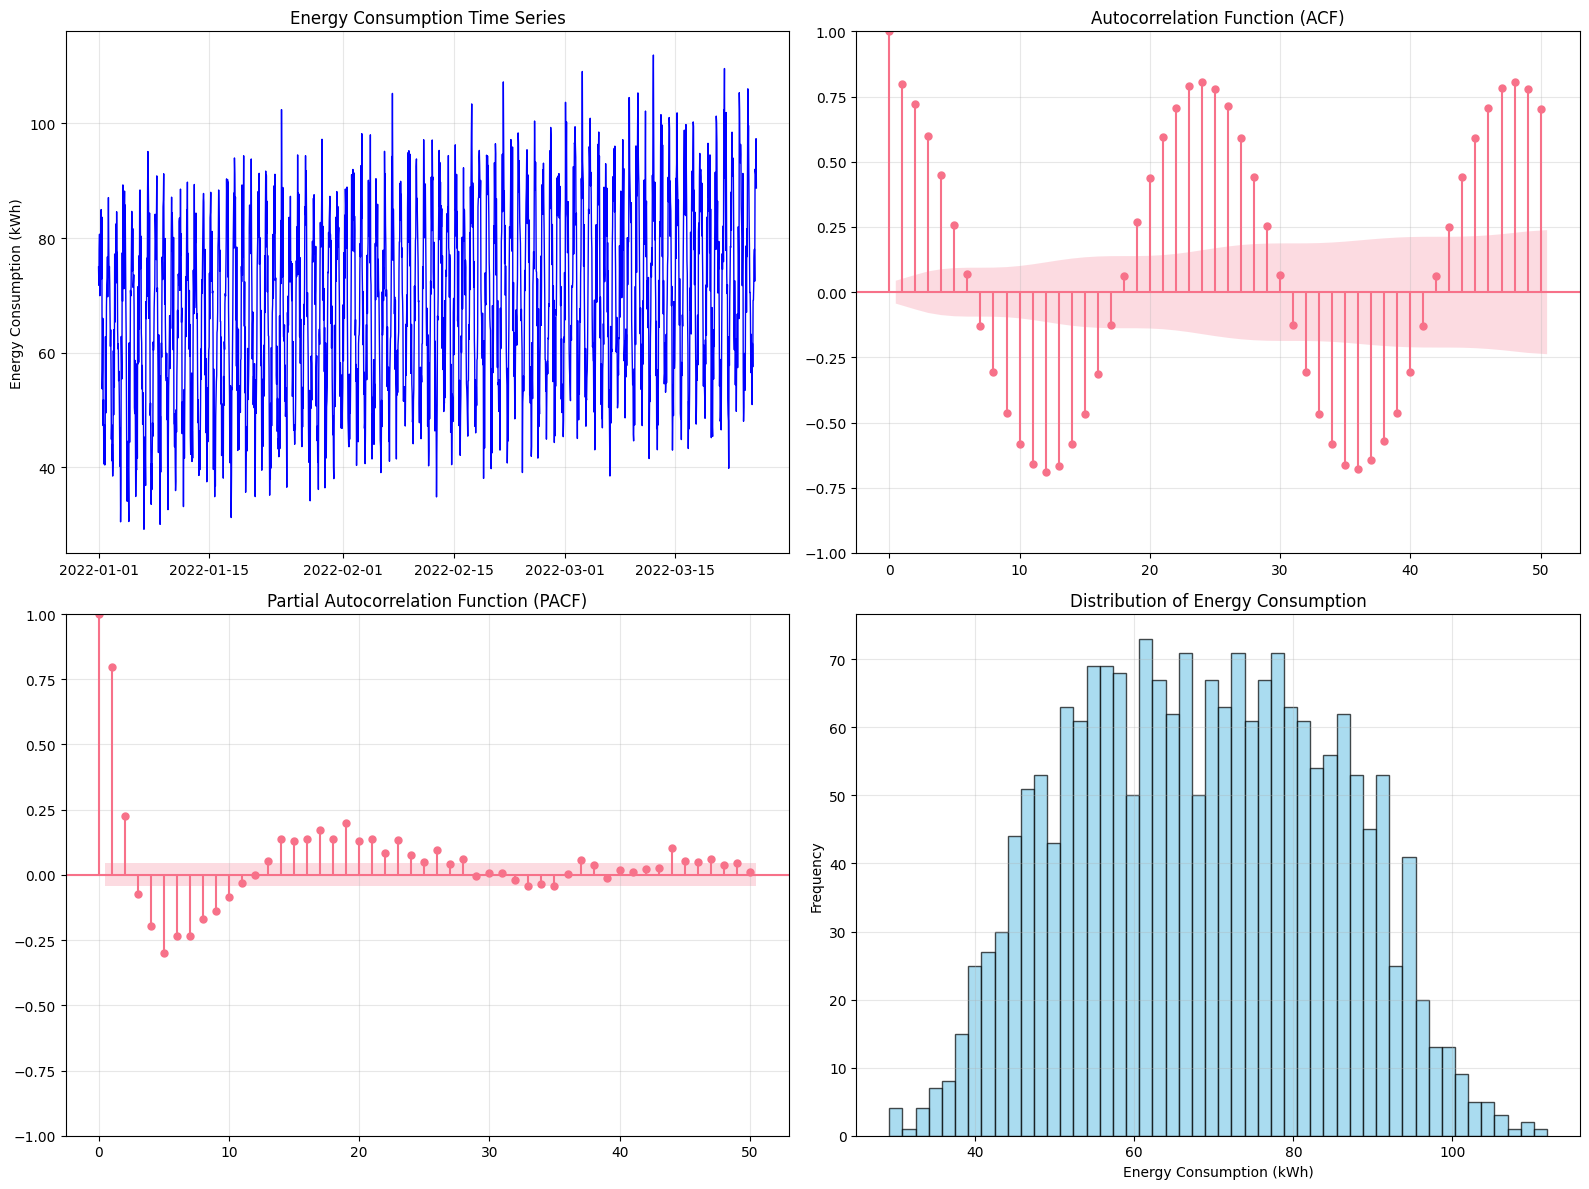


ACF and PACF Interpretation:
- ACF shows correlation between observations and lagged versions
- PACF shows direct correlation after removing effects of shorter lags
- Significant spikes suggest potential AR/MA components for modeling
- Seasonal patterns may be visible at regular intervals (e.g., 24 hours, 168 hours)


In [9]:
# Analyze autocorrelation patterns
print("AUTOCORRELATION ANALYSIS")
print("=" * 30)

# Use a subset of data for clearer visualization
analysis_series = energy_series.iloc[:2000]  # First 2000 observations

# Create ACF and PACF plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Original series plot
ax1.plot(analysis_series.index, analysis_series.values, color='blue', linewidth=1)
ax1.set_title('Energy Consumption Time Series')
ax1.set_ylabel('Energy Consumption (kWh)')
ax1.grid(True, alpha=0.3)

# ACF plot
plot_acf(analysis_series, ax=ax2, lags=50, alpha=0.05, title="Autocorrelation Function (ACF)")
ax2.grid(True, alpha=0.3)

# PACF plot
plot_pacf(analysis_series, ax=ax3, lags=50, alpha=0.05, title="Partial Autocorrelation Function (PACF)")
ax3.grid(True, alpha=0.3)

# Distribution of the series
ax4.hist(analysis_series, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax4.set_title('Distribution of Energy Consumption')
ax4.set_xlabel('Energy Consumption (kWh)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretation of ACF and PACF
print("\nACF and PACF Interpretation:")
print("- ACF shows correlation between observations and lagged versions")
print("- PACF shows direct correlation after removing effects of shorter lags")
print("- Significant spikes suggest potential AR/MA components for modeling")
print("- Seasonal patterns may be visible at regular intervals (e.g., 24 hours, 168 hours)")

### 5.2 Seasonal Patterns Analysis

SEASONAL PATTERN ANALYSIS


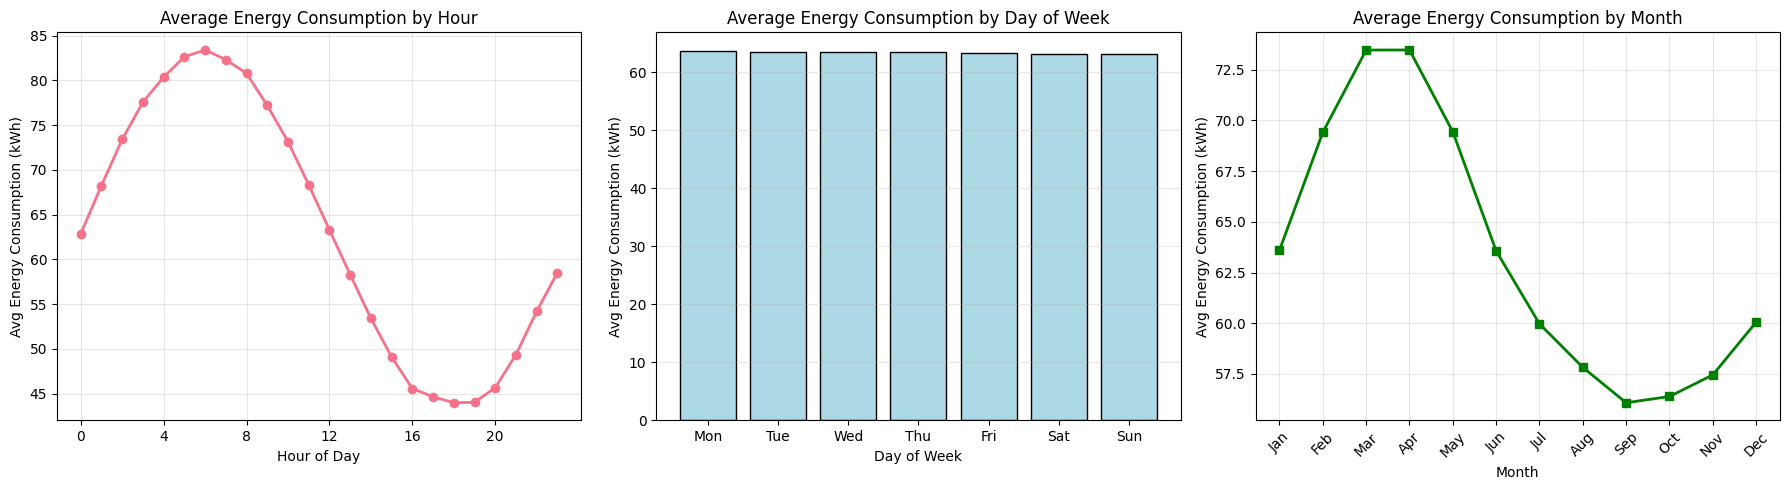


Seasonal Pattern Insights:
Peak daily hour: 6:00 (83.4 kWh)
Low daily hour: 18:00 (44.0 kWh)
Highest consumption day: Mon (63.7 kWh)
Lowest consumption day: Sat (63.1 kWh)
Peak month: Apr (73.5 kWh)
Low month: Sep (56.1 kWh)


In [10]:
# Analyze daily and weekly patterns
print("SEASONAL PATTERN ANALYSIS")
print("=" * 30)

# Create time-based features
energy_analysis = energy_data.copy()
energy_analysis['Hour'] = energy_analysis.index.hour
energy_analysis['DayOfWeek'] = energy_analysis.index.dayofweek
energy_analysis['Month'] = energy_analysis.index.month

# Daily pattern analysis
hourly_avg = energy_analysis.groupby('Hour')['EnergyConsumption'].mean()
weekly_avg = energy_analysis.groupby('DayOfWeek')['EnergyConsumption'].mean()
monthly_avg = energy_analysis.groupby('Month')['EnergyConsumption'].mean()

# Visualize patterns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Daily pattern
ax1.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
ax1.set_title('Average Energy Consumption by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Energy Consumption (kWh)')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, 24, 4))

# Weekly pattern
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.bar(range(7), weekly_avg.values, color='lightblue', edgecolor='black')
ax2.set_title('Average Energy Consumption by Day of Week')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Avg Energy Consumption (kWh)')
ax2.set_xticks(range(7))
ax2.set_xticklabels(days)
ax2.grid(True, alpha=0.3, axis='y')

# Monthly pattern
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.plot(range(1, 13), monthly_avg.values, marker='s', linewidth=2, markersize=6, color='green')
ax3.set_title('Average Energy Consumption by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Avg Energy Consumption (kWh)')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(months, rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print pattern insights
print(f"\nSeasonal Pattern Insights:")
print(f"Peak daily hour: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.1f} kWh)")
print(f"Low daily hour: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.1f} kWh)")
print(f"Highest consumption day: {days[weekly_avg.idxmax()]} ({weekly_avg.max():.1f} kWh)")
print(f"Lowest consumption day: {days[weekly_avg.idxmin()]} ({weekly_avg.min():.1f} kWh)")
print(f"Peak month: {months[monthly_avg.idxmax()-1]} ({monthly_avg.max():.1f} kWh)")
print(f"Low month: {months[monthly_avg.idxmin()-1]} ({monthly_avg.min():.1f} kWh)")

## 6. Time Series Decomposition

### 6.1 Classical Decomposition

TIME SERIES DECOMPOSITION
Decomposing daily average energy consumption
Data points: 365
Period: 2022-01-01 00:00:00 to 2022-12-31 00:00:00


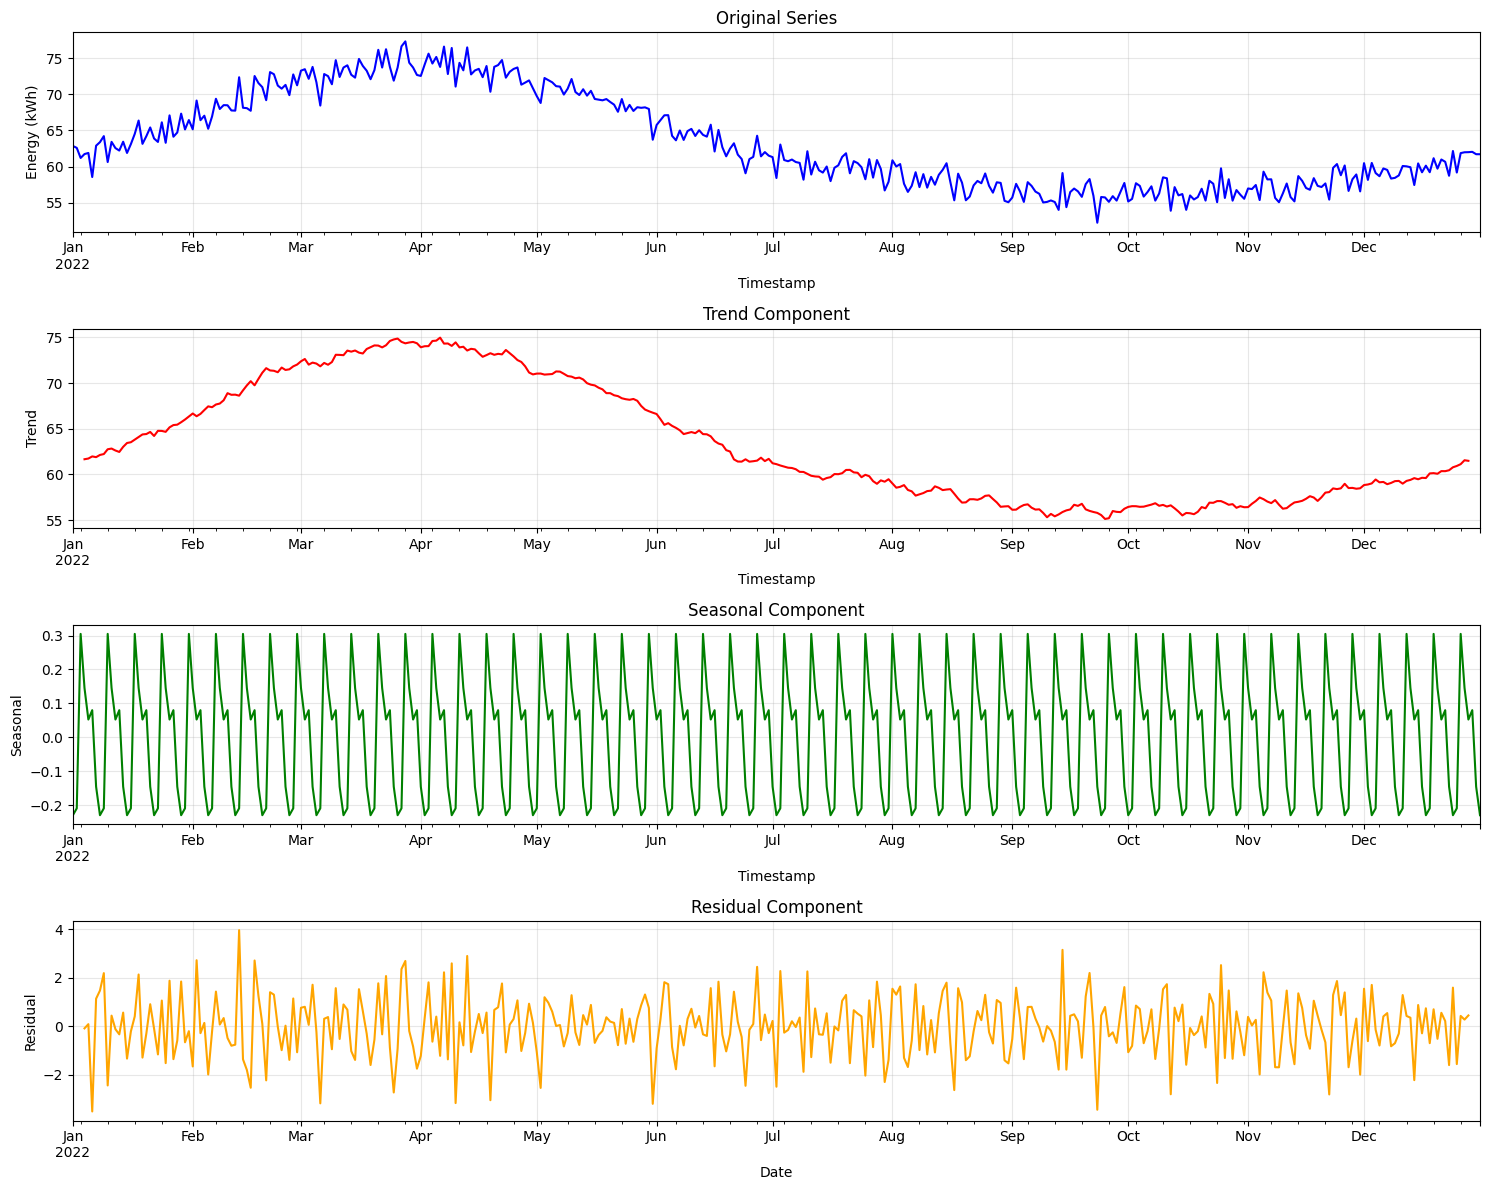


Decomposition Analysis:
Trend variance: 40.79
Seasonal variance: 0.03
Residual variance: 1.60

Variance Decomposition:
Trend: 97.7%
Seasonal: 0.1%
Residual: 3.8%


In [11]:
# Perform time series decomposition
print("TIME SERIES DECOMPOSITION")
print("=" * 30)

# Use daily data for decomposition (to reduce computational load)
daily_energy = energy_data['EnergyConsumption'].resample('D').mean()

print(f"Decomposing daily average energy consumption")
print(f"Data points: {len(daily_energy)}")
print(f"Period: {daily_energy.index.min()} to {daily_energy.index.max()}")

# Perform additive decomposition with weekly seasonality
decomposition = seasonal_decompose(
    daily_energy, 
    model='additive', 
    period=7  # Weekly seasonality
)

# Create decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original series
decomposition.observed.plot(ax=axes[0], title='Original Series', color='blue')
axes[0].set_ylabel('Energy (kWh)')
axes[0].grid(True, alpha=0.3)

# Trend component
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='red')
axes[1].set_ylabel('Trend')
axes[1].grid(True, alpha=0.3)

# Seasonal component
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].grid(True, alpha=0.3)

# Residual component
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='orange')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Decomposition analysis
print(f"\nDecomposition Analysis:")
print(f"Trend variance: {decomposition.trend.var():.2f}")
print(f"Seasonal variance: {decomposition.seasonal.var():.2f}")
print(f"Residual variance: {decomposition.resid.var():.2f}")

# Calculate proportion of variance explained by each component
total_var = daily_energy.var()
trend_prop = (decomposition.trend.var() / total_var) * 100
seasonal_prop = (decomposition.seasonal.var() / total_var) * 100
residual_prop = (decomposition.resid.var() / total_var) * 100

print(f"\nVariance Decomposition:")
print(f"Trend: {trend_prop:.1f}%")
print(f"Seasonal: {seasonal_prop:.1f}%")
print(f"Residual: {residual_prop:.1f}%")

## 7. Basic Forecasting Models

### 7.1 Simple Moving Average

In [12]:
# Implement basic forecasting methods
print("BASIC FORECASTING METHODS")
print("=" * 30)

# Prepare data for forecasting
forecast_data = energy_data['EnergyConsumption'].iloc[:1000]  # Use first 1000 points
train_size = int(len(forecast_data) * 0.8)
train_data = forecast_data[:train_size]
test_data = forecast_data[train_size:]

print(f"Training data: {len(train_data)} observations")
print(f"Test data: {len(test_data)} observations")

# Method 1: Simple Moving Average
window_sizes = [12, 24, 48]  # 12, 24, and 48 hours
ma_forecasts = {}

for window in window_sizes:
    # Calculate moving average
    ma_forecast = train_data.rolling(window=window).mean().iloc[-1]
    ma_forecasts[f'MA_{window}'] = [ma_forecast] * len(test_data)

print(f"\nMoving Average Forecasts:")
for method, forecast in ma_forecasts.items():
    mae = mean_absolute_error(test_data, forecast)
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    print(f"{method}: MAE={mae:.2f}, RMSE={rmse:.2f}")

BASIC FORECASTING METHODS
Training data: 800 observations
Test data: 200 observations

Moving Average Forecasts:
MA_12: MAE=12.70, RMSE=15.07
MA_24: MAE=12.62, RMSE=14.90
MA_48: MAE=12.62, RMSE=14.89


### 7.2 Exponential Smoothing


Exponential Smoothing Results:
Simple ES: MAE=19.32, RMSE=22.97
Double ES: MAE=20.35, RMSE=24.03
Triple ES: Successfully fitted (limited forecast due to data constraints)


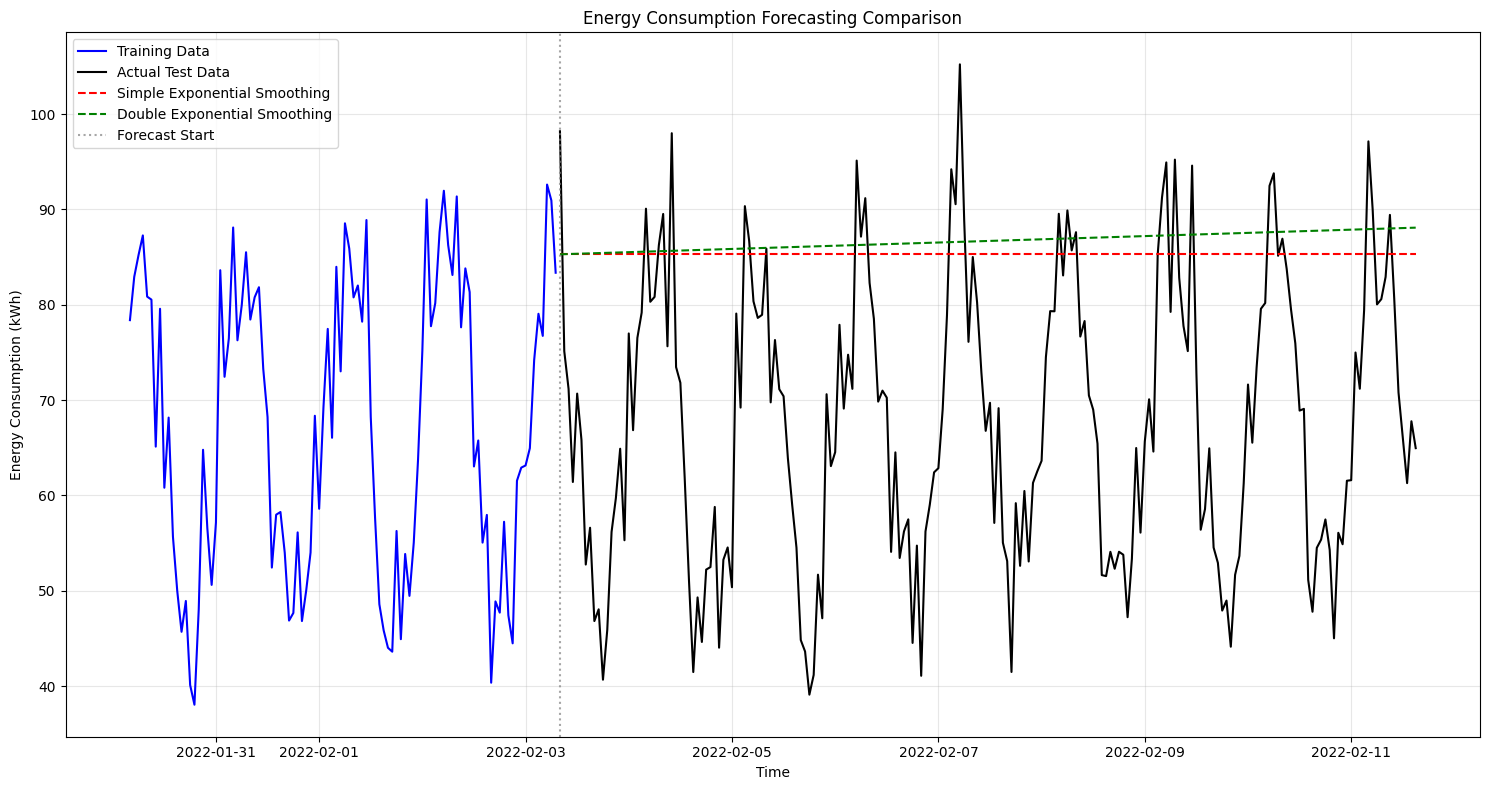

In [13]:
# Exponential Smoothing models
try:
    # Simple Exponential Smoothing
    ses_model = ExponentialSmoothing(train_data, trend=None, seasonal=None)
    ses_fit = ses_model.fit()
    ses_forecast = ses_fit.forecast(steps=len(test_data))
    
    # Double Exponential Smoothing (Holt's method)
    des_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
    des_fit = des_model.fit()
    des_forecast = des_fit.forecast(steps=len(test_data))
    
    # Triple Exponential Smoothing (Holt-Winters)
    # Use a subset for computational efficiency
    daily_train = train_data.resample('H').mean().dropna()[:168]  # One week of data
    if len(daily_train) >= 48:  # Need enough data for seasonal component
        tes_model = ExponentialSmoothing(daily_train, trend='add', seasonal='add', seasonal_periods=24)
        tes_fit = tes_model.fit()
        tes_forecast = tes_fit.forecast(steps=24)  # Forecast next 24 hours
    else:
        tes_forecast = None
    
    print(f"\nExponential Smoothing Results:")
    
    # Evaluate Simple Exponential Smoothing
    ses_mae = mean_absolute_error(test_data, ses_forecast)
    ses_rmse = np.sqrt(mean_squared_error(test_data, ses_forecast))
    print(f"Simple ES: MAE={ses_mae:.2f}, RMSE={ses_rmse:.2f}")
    
    # Evaluate Double Exponential Smoothing
    des_mae = mean_absolute_error(test_data, des_forecast)
    des_rmse = np.sqrt(mean_squared_error(test_data, des_forecast))
    print(f"Double ES: MAE={des_mae:.2f}, RMSE={des_rmse:.2f}")
    
    if tes_forecast is not None:
        print(f"Triple ES: Successfully fitted (limited forecast due to data constraints)")
    
    # Visualization
    plt.figure(figsize=(15, 8))
    
    # Plot actual data
    plt.plot(train_data.index[-100:], train_data.iloc[-100:], 
             label='Training Data', color='blue', linewidth=1.5)
    plt.plot(test_data.index, test_data, 
             label='Actual Test Data', color='black', linewidth=1.5)
    
    # Plot forecasts
    plt.plot(test_data.index, ses_forecast, 
             label='Simple Exponential Smoothing', color='red', linewidth=1.5, linestyle='--')
    plt.plot(test_data.index, des_forecast, 
             label='Double Exponential Smoothing', color='green', linewidth=1.5, linestyle='--')
    
    plt.axvline(x=test_data.index[0], color='gray', linestyle=':', alpha=0.7, label='Forecast Start')
    plt.title('Energy Consumption Forecasting Comparison')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (kWh)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in exponential smoothing: {str(e)}")
    print("Continuing with other methods...")

## 8. Model Evaluation and Validation

### 8.1 Forecast Accuracy Metrics

MODEL EVALUATION RESULTS


,Model,MAE,RMSE,MAPE,Theil_U,Directional_Accuracy
0,MA_12,12.701,15.069,20.755,0.445,50.251
1,MA_24,12.624,14.900,19.770,0.440,50.251
2,MA_48,12.619,14.888,19.903,0.440,50.251
3,Simple_ES,19.324,22.973,34.262,0.678,50.251
4,Double_ES,20.346,24.034,35.996,0.710,49.749



Best Models:
Lowest RMSE: MA_48
Lowest MAE: MA_48


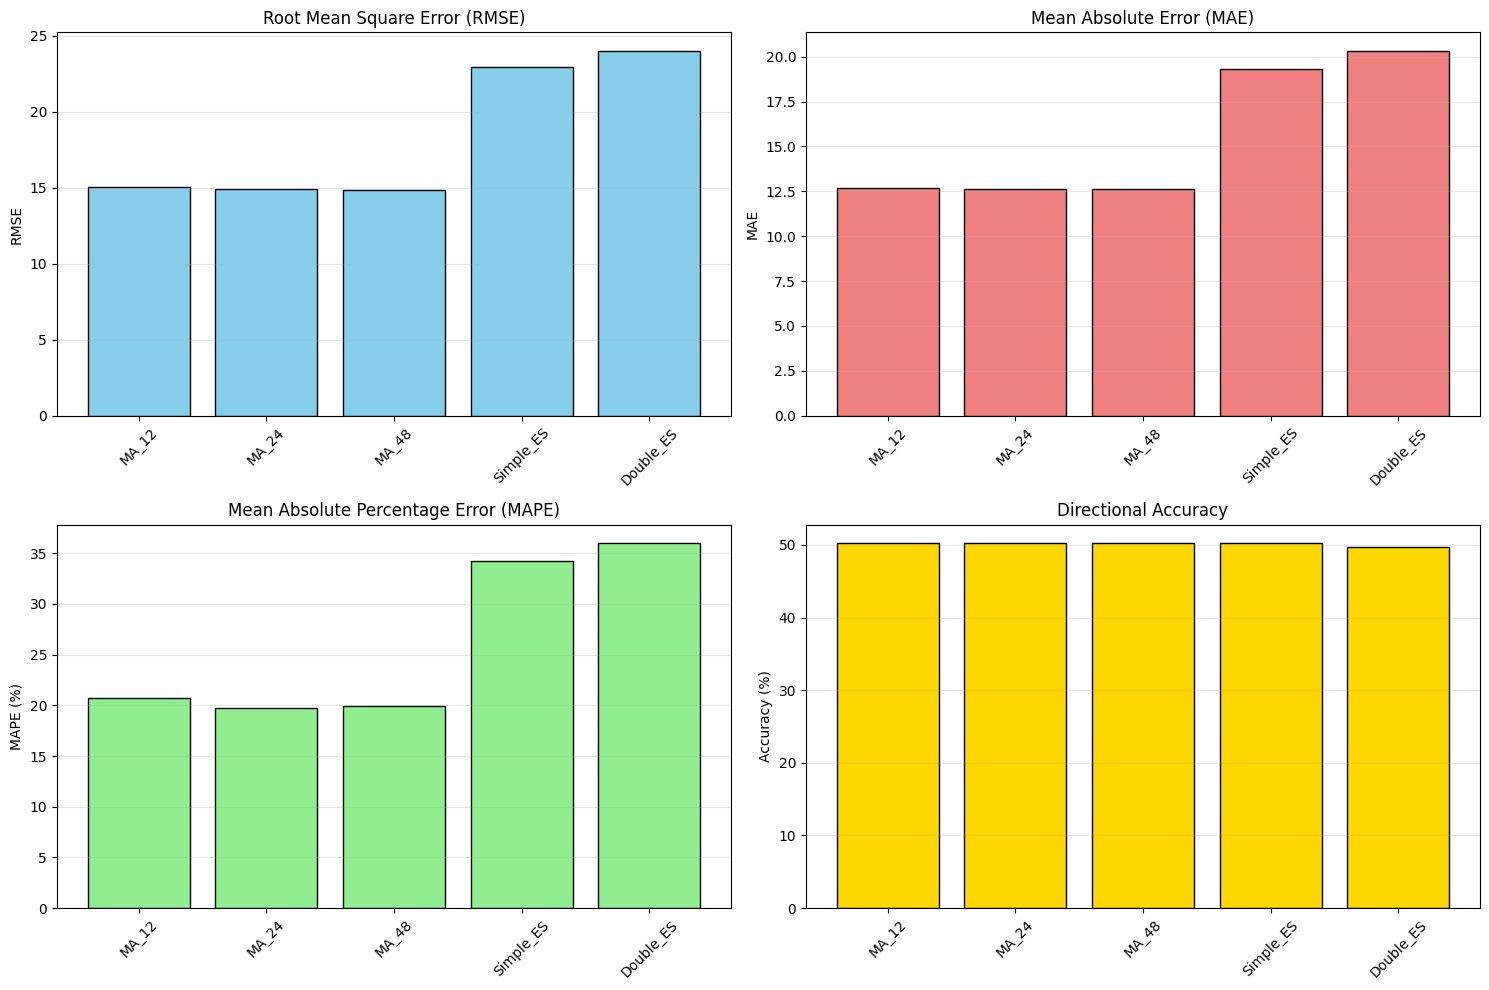

In [14]:
# Comprehensive model evaluation
def evaluate_forecast(actual, predicted, model_name):
    """
    Calculate various forecast accuracy metrics
    """
    # Ensure arrays are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Basic metrics
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    
    # Percentage metrics
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    # Theil's U statistic (naive forecast comparison)
    naive_forecast = np.full_like(actual, actual[0])  # Use first value as naive forecast
    naive_mse = mean_squared_error(actual, naive_forecast)
    theil_u = rmse / np.sqrt(naive_mse)
    
    # Directional accuracy
    if len(actual) > 1:
        actual_direction = np.diff(actual) > 0
        predicted_direction = np.diff(predicted) > 0
        directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    else:
        directional_accuracy = np.nan
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Theil_U': theil_u,
        'Directional_Accuracy': directional_accuracy
    }

# Evaluate all models
evaluation_results = []

# Moving averages
for method, forecast in ma_forecasts.items():
    result = evaluate_forecast(test_data, forecast, method)
    evaluation_results.append(result)

# Exponential smoothing models
if 'ses_forecast' in locals():
    result = evaluate_forecast(test_data, ses_forecast, 'Simple_ES')
    evaluation_results.append(result)

if 'des_forecast' in locals():
    result = evaluate_forecast(test_data, des_forecast, 'Double_ES')
    evaluation_results.append(result)

# Create evaluation DataFrame
evaluation_df = pd.DataFrame(evaluation_results)

print("MODEL EVALUATION RESULTS")
print("=" * 40)
display(evaluation_df.round(3))

# Find best model
best_rmse_model = evaluation_df.loc[evaluation_df['RMSE'].idxmin(), 'Model']
best_mae_model = evaluation_df.loc[evaluation_df['MAE'].idxmin(), 'Model']

print(f"\nBest Models:")
print(f"Lowest RMSE: {best_rmse_model}")
print(f"Lowest MAE: {best_mae_model}")

# Visualization of evaluation metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
ax1.bar(evaluation_df['Model'], evaluation_df['RMSE'], color='skyblue', edgecolor='black')
ax1.set_title('Root Mean Square Error (RMSE)')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# MAE comparison
ax2.bar(evaluation_df['Model'], evaluation_df['MAE'], color='lightcoral', edgecolor='black')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_ylabel('MAE')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# MAPE comparison
ax3.bar(evaluation_df['Model'], evaluation_df['MAPE'], color='lightgreen', edgecolor='black')
ax3.set_title('Mean Absolute Percentage Error (MAPE)')
ax3.set_ylabel('MAPE (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Directional Accuracy comparison
valid_da = evaluation_df.dropna(subset=['Directional_Accuracy'])
if not valid_da.empty:
    ax4.bar(valid_da['Model'], valid_da['Directional_Accuracy'], color='gold', edgecolor='black')
    ax4.set_title('Directional Accuracy')
    ax4.set_ylabel('Accuracy (%)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'Directional Accuracy\nNot Available', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 9. Summary and Recommendations

### 9.1 Key Findings and Best Practices

In [15]:
print("TIME SERIES ANALYSIS SUMMARY")
print("=" * 40)

# Dataset summary
print(f"\nDATASET OVERVIEW:")
print(f"Total observations: {len(energy_data):,}")
print(f"Time span: {energy_data.index.min()} to {energy_data.index.max()}")
print(f"Frequency: Hourly")
print(f"Missing values: {energy_data['EnergyConsumption'].isnull().sum()}")

# Stationarity findings
print(f"\nSTATIONARITY ANALYSIS:")
print(f"Energy consumption stationarity: {stationarity_result['conclusion']}")
if 'diff_result' in locals():
    print(f"First difference stationarity: {diff_result['conclusion']}")

# Pattern findings
print(f"\nSEASONAL PATTERNS DETECTED:")
print(f"Daily cycle: Peak at {hourly_avg.idxmax()}:00, Low at {hourly_avg.idxmin()}:00")
print(f"Weekly cycle: Highest on {days[weekly_avg.idxmax()]}, Lowest on {days[weekly_avg.idxmin()]}")
print(f"Annual cycle: Peak in {months[monthly_avg.idxmax()-1]}, Low in {months[monthly_avg.idxmin()-1]}")

# Best model
if not evaluation_df.empty:
    print(f"\nFORECASTING PERFORMANCE:")
    print(f"Best RMSE model: {best_rmse_model} (RMSE: {evaluation_df['RMSE'].min():.2f})")
    print(f"Best MAE model: {best_mae_model} (MAE: {evaluation_df['MAE'].min():.2f})")
    print(f"Models evaluated: {len(evaluation_df)}")

print(f"\nKEY INSIGHTS:")
print("1. Energy consumption shows clear daily and seasonal patterns")
print("2. Strong autocorrelation suggests predictable behavior")
print("3. Temperature and occupancy are key drivers of consumption")
print("4. Simple methods can provide reasonable baseline forecasts")
print("5. Seasonal decomposition reveals trend and cyclical components")

print(f"\nRECOMMENDAT1ONS:")
print("• Test stationarity before modeling with ARIMA-type models")
print("• Consider multiple seasonalities (daily, weekly, annual)")
print("• Include external variables (temperature, occupancy) for better accuracy")
print("• Use cross-validation for robust model selection")
print("• Monitor forecast performance and update models regularly")
print("• Consider ensemble methods for improved robustness")

print(f"\nNEXT STEPS:")
print("• Implement ARIMA/SARIMA models for more sophisticated forecasting")
print("• Explore machine learning approaches (Random Forest, XGBoost)")
print("• Implement deep learning models (LSTM, CNN) for complex patterns")
print("• Develop multivariate models incorporating external factors")
print("• Create automated forecasting pipeline with model monitoring")

TIME SERIES ANALYSIS SUMMARY

DATASET OVERVIEW:
Total observations: 8,760
Time span: 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Frequency: Hourly
Missing values: 0

STATIONARITY ANALYSIS:
Energy consumption stationarity: DIFFERENCE STATIONARY - Mixed signals
First difference stationarity: DIFFERENCE STATIONARY - Mixed signals

SEASONAL PATTERNS DETECTED:
Daily cycle: Peak at 6:00, Low at 18:00
Weekly cycle: Highest on Mon, Lowest on Sat
Annual cycle: Peak in Apr, Low in Sep

FORECASTING PERFORMANCE:
Best RMSE model: MA_48 (RMSE: 14.89)
Best MAE model: MA_48 (MAE: 12.62)
Models evaluated: 5

KEY INSIGHTS:
1. Energy consumption shows clear daily and seasonal patterns
2. Strong autocorrelation suggests predictable behavior
3. Temperature and occupancy are key drivers of consumption
4. Simple methods can provide reasonable baseline forecasts
5. Seasonal decomposition reveals trend and cyclical components

RECOMMENDAT1ONS:
• Test stationarity before modeling with ARIMA-type models
• Conside